In [57]:
####### Run a radar blockage analysis within CONUS using GEE layers

# Step 1: Sign up for a Google Earth Engine Account here:
# https://earthengine.google.com/signup/

# you will use this to authenticate your account with GEE to run the script and
# utilize GEE layers

In [ ]:
! pip install wradlib earthengine-api geemap

In [16]:
# setup modules
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import sys,os,os.path,tempfile

# spatial modules
import ee
#import geemap # currently not using as colorbars dont load properly in google collab
import geemap.colormaps as cm
import geemap.foliumap as geemap # use folium instead so coloramps work on goolge collab
import warnings

# palette -- old
#https://jiffyclub.github.io/palettable/
#palettable
#https://cmasher.readthedocs.io/user/usage.html#taking-colormap-colors
#import cmasher as cmr
#

warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

## setup output. defined dir or system temp dir
data_dir=os.path.expanduser(os.path.join(tempfile.gettempdir(),'geo'))

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print(data_dir)

os.environ['WRADLIB_DATA']=os.path.expanduser(data_dir)
print(os.environ['WRADLIB_DATA'])

/var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo
/var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo


In [5]:
##### initialize ee API  - you need to authenticate with GEE and initialize

## Trigger the authentication flow. You only need to do this once while running notebook
ee.Authenticate()

## After inserting the API key initialize GEE
ee.Initialize()


In [17]:
### Select from the list of existing sites or put in your own long, lat, and radar altitude

################# List of potential radar sites #################
#Courtland,AL airport
#sitecoords = (-87.3401, 34.6554, 179)
#sitecoords = (-87.3387, 34.6455, 179) -- slightly better location
#Moulton, AL region
#sitecoords = (-87.4634, 34.552, 185.0)
#Columbus, MS region
#sitecoords  = (-88.4273, 33.4957, 66.0)
#Cornersvill, TN region
#sitecoords  = (-86.85, 35.1, 205)
#Clanton, AL region
#sitecoords = (-86.6294,32.8387, 182)
#Tupulo, MS region
#sitecoords = (-88.7034, 34.2576, 85)
#Muscle Shoals, AL, region
#sitecoords =(-87.65, 34.7448, 152)
#Rome, GA
#sitecoords = (-85.4, 34.2, 187)
################# List of potential radar sites #################

################# Insert long, lat, atl here ####################
#Courtland,AL airport
sitecoords = (-87.3387, 34.6455, 179)
radar_height = 10 # in meters. Added to the altitude above
# set to 0 if you want to assume the radar is at ground level

sitecoords = (sitecoords[0],sitecoords[1],sitecoords[2]+radar_height)
print(sitecoords)
#################################################################


#################################################################
## Options
# see: https://docs.wradlib.org/en/stable/notebooks/beamblockage/wradlib_beamblock.html
nrays = 360 # number of rays
nbins = 1000 # number of range bins
el = 1.0 # vertical antenna pointing angle (deg)
bw = 1.0 # half power beam width (deg)
range_res = 100. # range resolution (meters) ?? kilometers?
#################################################################

(-87.3387, 34.6455, 189)


In [18]:
#Create the range, azimuth, and beamradius arrays.
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [19]:
# Calculate the spherical coordinates of the bin centroids and their longitude, latitude and altitude.
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

polcoords = coords[..., :2]
print("spherical lon,lat,alt:", coords.shape)

spherical lon,lat,alt: (360, 1000, 3)


In [20]:
# Create radar bounding box
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))
#bbox = ee.Geometry.Rectangle(-94.614744,29.317645,-74.441221,36.520919)

Radar bounding box:
	35.55
-88.43             -86.25
	33.74


In [21]:
### Get GEE imagery

# DEM
elev_dataset = ee.Image('USGS/NED')
ned_elevation = elev_dataset.select('elevation')
#colors = cmr.take_cmap_colors('viridis', 5, return_fmt='hex')
#colors = cmr.take_cmap_colors('viridis', None, cmap_range=(0.2, 0.8), return_fmt='hex')
#dem_palette = cmr.take_cmap_colors(mpl.cm.get_cmap('Spectral', 30).reversed(),30, return_fmt='hex')
dem_palette = cm.get_palette('Spectral_r', n_class=30)
demViz = {'min': 0.0, 'max': 2000.0, 'palette': dem_palette, 'opacity': 1}

# LandFire
lf = ee.ImageCollection('LANDFIRE/Vegetation/EVH/v1_4_0');
lf_evh = lf.select('EVH')
#evh_palette = cmr.take_cmap_colors(mpl.cm.get_cmap('Spectral', 30).reversed(),30, return_fmt='hex')
evh_palette = cm.get_palette('Spectral_r', n_class=30)
evhViz = {'min': 0.0, 'max': 30.0, 'palette': evh_palette, 'opacity': 1}

# Global Forest Canopy Height (2005)
gfch = ee.Image('NASA/JPL/global_forest_canopy_height_2005');
forestCanopyHeight = gfch.select('1');
#gfch_palette = cmr.take_cmap_colors(mpl.cm.get_cmap('Spectral', 30).reversed(),30, return_fmt='hex')
gfch_palette = cm.get_palette('Spectral_r', n_class=30)
gfchViz = {'min': 0.0, 'max': 40.0, 'palette': gfch_palette, 'opacity': 1}

In [22]:
### Plot the elevation data

# Prints the elevation of Mount Everest.
xy = ee.Geometry.Point(sitecoords[:2])
site_elev = ned_elevation.sample(xy, 30).first().get('elevation').getInfo()
print('Selected site elevation (m):', site_elev)

# display NED data
# https://geemap.org/notebooks/14_legends/
# https://geemap.org/notebooks/49_colorbar/
# https://colab.research.google.com/github/fsn1995/GIS-at-deep-purple/blob/main/02%20gee%20map%20greenland.ipynb#scrollTo=uwLvDKHDlN0l
#colors = demViz['palette']
#vmin = demViz['min']
#vmax = demViz['max']

srtm = geemap.Map(center=[33.315809,-85.198609], zoom=6)
srtm.addLayer(ned_elevation, demViz, 'Elevation above sea level');
srtm.addLayer(xy, {'color': 'black', 'strokeWidth': 1}, 'Selected Site')
#srtm.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, label="Elevation (m)", 
#                         orientation="vertical", layer_name="SRTM DEM")
#srtm.add_colorbar(demViz, label="Elevation (m)", 
#                  layer_name="SRTM DEM", position="bottomright")
srtm.add_colorbar(colors=demViz['palette'], vmin=demViz['min'], 
                  vmax=demViz['max'], label="Elevation (m)", 
                  layer_name="SRTM DEM", position="bottomright")
states = ee.FeatureCollection('TIGER/2018/States')
statesImage = ee.Image().paint(states, 0, 2)
srtm.addLayer(statesImage, {'palette': 'black'}, 'US States')
srtm.addLayerControl()
srtm

Selected site elevation (m): 173.21658325195312


In [26]:
### Plot the Tree Height data
vh = geemap.Map(center=[33.315809,-85.198609], zoom=6)
#evh.addLayer(lf_evh, evhViz, 'LandFire Existing Vegetation Height (m)')
vh.addLayer(forestCanopyHeight, gfchViz, 'Global Forest Canopy Height (2005, in meters)')
vh.addLayer(xy, {'color': 'black', 'strokeWidth': 1}, 'Selected Site')

#vh.add_colorbar(gfchViz, label="Global Forest Canopy Height (2005, in meters)", 
#                layer_name="Global Forest Canopy Height")
vh.add_colorbar(colors=gfchViz['palette'], vmin=demViz['min'], vmax=demViz['max'],
                label='Global Forest Canopy Height (2005, in meters)', 
                layer_name='Global Forest Canopy Height', position='bottomright',
                orientation='vertical')
states = ee.FeatureCollection('TIGER/2018/States')
statesImage = ee.Image().paint(states, 0, 2)
vh.addLayer(statesImage, {'palette': 'black'}, 'US States')
vh.addLayerControl()
vh

In [24]:
# get 30m SRTM dataset - output to scratch space
rlimits2 = ee.Geometry.Polygon([[[lon.min(),lat.max()],[lon.max(),lat.max()],
             [lon.max(),lat.min()],[lon.min(),lat.min()]]])
feature = ee.Feature(rlimits2, {})
roi = feature.geometry()
filename = os.path.join(data_dir, 'amf3_dem.tif')
clip_dem = ned_elevation.clip(roi).unmask()
geemap.ee_export_image(clip_dem, filename=filename, scale=100, region=roi, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo/amf3_dem.tif


In [25]:
# get 30m gfch - output to scratch space
filename = os.path.join(data_dir, 'amf3_gfch.tif')
clip_gfch = forestCanopyHeight.clip(roi).unmask()
geemap.ee_export_image(clip_gfch, filename=filename, scale=100, region=roi, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo/amf3_gfch.tif


In [27]:
# add DEM and GFCH data together
combined = ned_elevation.add(forestCanopyHeight)
filename = os.path.join(data_dir, 'amf3_combined_dem.tif')
clip_combined = combined.clip(roi).unmask()
geemap.ee_export_image(clip_combined, filename=filename, scale=100, region=roi, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo/amf3_combined_dem.tif


In [28]:
#### get DEM raster generated in previous step

# use just DEM
#rasterfile = wrl.util.get_wradlib_data_file(os.path.join(data_dir,'amf3_dem.tif'))

# use DEM+tree height
rasterfile = wrl.util.get_wradlib_data_file(os.path.join(data_dir,'amf3_combined_dem.tif'))

# selected 
print(rasterfile)

# open the raster
ds = wrl.io.open_raster(rasterfile)
# extract raster info
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)
print(proj)

/var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/geo/amf3_combined_dem.tif
GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101004,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


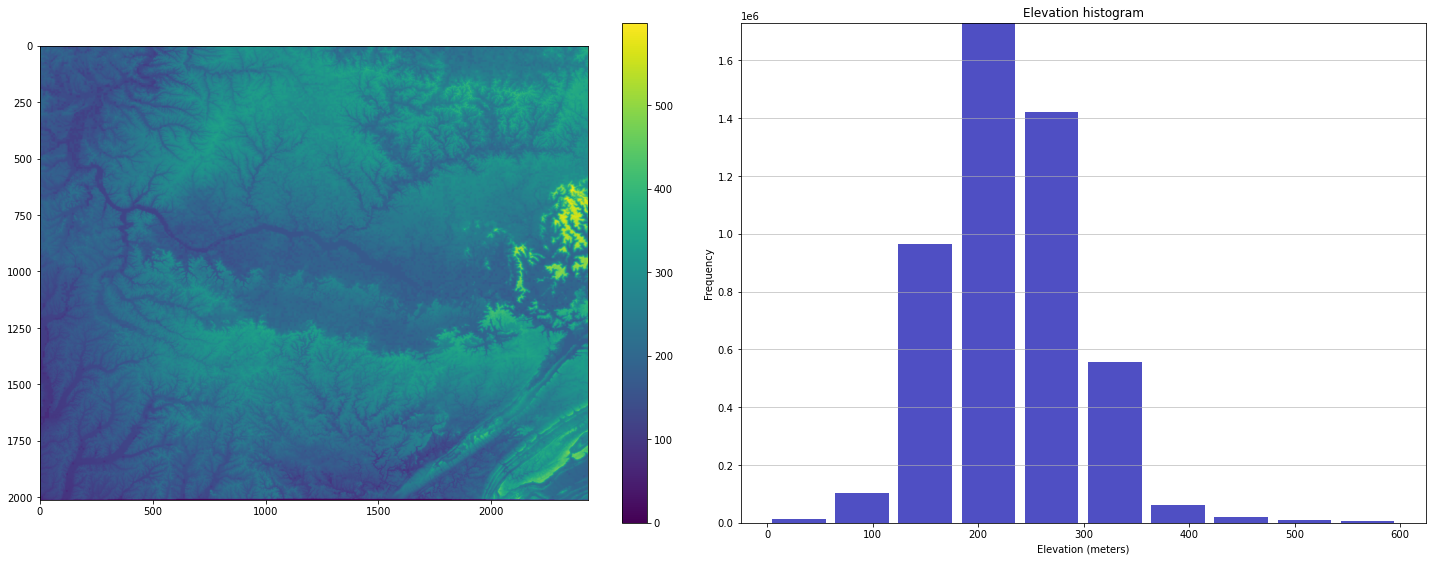

In [29]:
# quicklooks
fig = pl.figure(figsize=(20,15))
# generate a small quicklook of the DEM elevation data (meters)
fig.add_subplot(221)
pl.imshow(rastervalues)
pl.colorbar()

fig.add_subplot(222)
# generate histogram
for_hist = rastervalues.flatten()
n, bins, patches = pl.hist(x=for_hist, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
pl.grid(axis='y', alpha=0.75)
pl.xlabel('Elevation (meters)')
pl.ylabel('Frequency')
pl.title('Elevation histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
pl.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

pl.tight_layout()

# output quicklook and histogram
fig.savefig(os.path.join(data_dir,"dem_quicklook.pdf"), bbox_inches='tight')

In [30]:
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

In [31]:
# Calculate beam blockage
#Now we can finally apply the wradlib.qual.beam_block_frac function to calculate the PBB.

PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 1000)


In [32]:
#So far, we calculated the fraction of beam blockage for each bin.

#But we need to into account that the radar signal travels along a beam. 
#Cumulative beam blockage (CBB) in one bin along a beam will always be at 
#least as high as the maximum PBB of the preceeding bins (see wradlib.qual.cum_beam_block_frac)


CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 1000)


In [33]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        pl.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

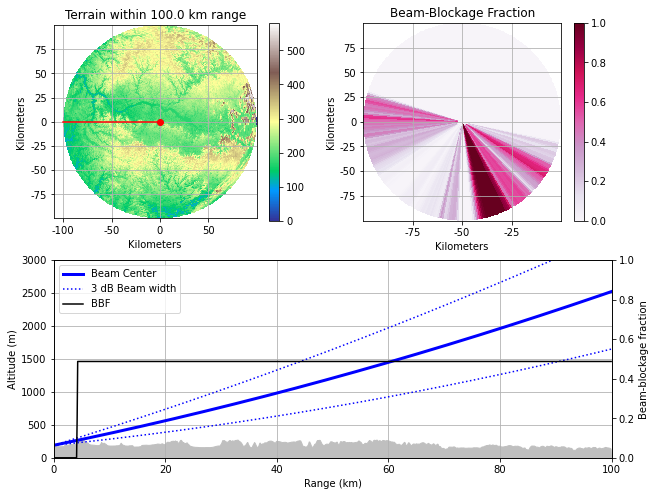

In [34]:
## create beam block figure
fig = pl.figure(figsize=(10, 8))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 270

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terrain within {0} km range'.format(np.max(r / 1000.) + 0.1))

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, 'Beam-Blockage Fraction')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

# output beamblock figure
fig.savefig(os.path.join(data_dir,"beamblockage.pdf"), bbox_inches='tight')

In [35]:
#Now we visualize - interaction with terrain along a single beam
#In this representation the earth curvature is shown. 
#For this we assume the earth a sphere with exactly 6370000 m radius. 
#This is needed to get the height ticks at nice position.

def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = '{:g}'.format(x)
    return fmt_str

def range_formatter(x, pos):
    x = x / 1000.
    fmt_str = '{:g}'.format(x)
    return fmt_str

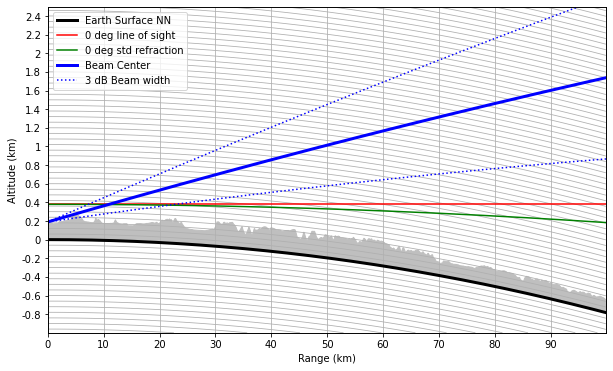

In [36]:
# create curvature plot
fig = pl.figure(figsize=(10, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
angle = 270

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins=80
gh.grid_finder.grid_locator2._steps=[1,2,4,5,10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = - np.degrees(ade/er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
bes, = paax.plot(thetap, ecp, '-k', linewidth=3, label='Earth Surface NN')
bc, = paax.plot(thetap, ecp + alt[angle, :], '-b', linewidth=3, label='Beam Center')
bc0r, = paax.plot(thetap, ecp + bh0 + alt[angle, 0] , '-g', label='0 deg Refraction')
bc0n, = paax.plot(thetap, ecp + bhe + alt[angle, 0], '-r', label='0 deg line of sight')
b3db, = paax.plot(thetap, ecp + alt[angle, :]  + beamradius, ':b', label='+3 dB Beam width')
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ':b', label='-3 dB Beam width')

# orography
paax.fill_between(thetap, ecp,
                  ecp + polarvalues[angle, :],
                  color='0.75')

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min()-1000, ecp.max()+2500])
caax.grid(True, axis='x')
cgax.grid(True, axis='y')
cgax.axis['top'].toggle(all=False)
caax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,4,5,10], nbins=20, prune='both'))
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel('Range (km)')
caax.set_ylabel('Altitude (km)')

legend = paax.legend((bes, bc0n, bc0r, bc, b3db),
                    ('Earth Surface NN', '0 deg line of sight', '0 deg std refraction', 'Beam Center', '3 dB Beam width'),
                    loc='upper left', fontsize=10)

# output beamblock figure
fig.savefig(os.path.join(data_dir,"earth_curvature_beamblockage.pdf"), bbox_inches='tight')